In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    mean_squared_error, 
    roc_auc_score, 
    f1_score, 
    accuracy_score,
    confusion_matrix,
    classification_report
)
import optuna
import lightgbm as lgb
# import xgboost as xgb
# from catboost import CatBoostClassifier, Pool
import warnings
warnings.filterwarnings('ignore')

# 再現性のためのシード設定
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
train_df = pd.read_csv("/home/takato/bita/bank/data/train.csv")
test_df = pd.read_csv("/home/takato/bita/bank/data/test.csv")

In [5]:
print(train_df.shape)
print("*"*50)
print(test_df.shape)

(27128, 18)
**************************************************
(18083, 17)


In [7]:
def feature_engineering(df, is_train=True, target_encoders=None):
    """
    特徴量エンジニアリング関数
    """
    df = df.copy()
    
    # 1. 数値特徴量の変換
    # 年齢グループ
    df['age_group'] = pd.cut(df['age'], bins=[0, 25, 35, 45, 55, 65, 100], 
                              labels=['0-25', '26-35', '36-45', '46-55', '56-65', '65+'])
    
    # balance の対数変換（負の値があるため調整）
    df['balance_log'] = np.log1p(df['balance'] - df['balance'].min() + 1)
    
    # 2. 時系列特徴量
    # dayとduration の比率
    df['duration_per_day'] = df['duration'] / (df['day'] + 1)
    
    # campaign効率
    df['campaign_efficiency'] = df['duration'] / (df['campaign'] + 1)
    
    # previous の成功率（pdaysが999でない場合）
    df['has_previous_contact'] = (df['pdays'] != 999).astype(int)
    df['previous_success_rate'] = df['previous'] / (df['pdays'].replace(999, 1) + 1)
    
    # 3. カテゴリカル変数の組み合わせ
    df['job_education'] = df['job'].astype(str) + '_' + df['education'].astype(str)
    df['marital_education'] = df['marital'].astype(str) + '_' + df['education'].astype(str)
    df['contact_month'] = df['contact'].astype(str) + '_' + df['month'].astype(str)
    
    # 4. ローン関連の特徴量
    df['total_loans'] = (df['housing'] == 'yes').astype(int) + (df['loan'] == 'yes').astype(int)
    df['has_any_loan'] = (df['total_loans'] > 0).astype(int)
    
    # 5. カテゴリカル変数のリスト
    categorical_feats = ['job', 'marital', 'education', 'default', 'housing', 
                         'loan', 'contact', 'month', 'poutcome', 
                         'age_group', 'job_education', 'marital_education', 'contact_month']
    
    # 6. Target Encoding（訓練データのみで学習）
    if is_train:
        target_encoders = {}
        for col in categorical_feats:
            # 元のターゲット値で平均を計算
            if 'y' in df.columns:
                target_mean = df.groupby(col)['y'].mean()
                target_encoders[col] = target_mean
                # Smoothingを適用
                global_mean = df['y'].mean()
                counts = df.groupby(col).size()
                smoothing = 10
                smooth_target = (target_mean * counts + global_mean * smoothing) / (counts + smoothing)
                df[f'{col}_target_enc'] = df[col].map(smooth_target)
    else:
        # テストデータには学習済みのエンコーダーを適用
        for col in categorical_feats:
            if col in target_encoders:
                df[f'{col}_target_enc'] = df[col].map(target_encoders[col])
                # 未知のカテゴリには平均値を使用
                df[f'{col}_target_enc'].fillna(target_encoders[col].mean(), inplace=True)
    
    # 7. Frequency Encoding
    for col in categorical_feats:
        freq = df[col].value_counts(normalize=True)
        df[f'{col}_freq'] = df[col].map(freq)
    
    # 8. Label Encoding（モデル用）
    label_encoders = {}
    for col in categorical_feats:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    
    return df, target_encoders if is_train else label_encoders

# 特徴量エンジニアリングを適用
train_processed, target_encoders = feature_engineering(train_df, is_train=True)
print("Feature engineering completed!")
print(f"New train shape: {train_processed.shape}")

Feature engineering completed!
New train shape: (27128, 55)


In [8]:
# ターゲットと特徴量の分離
y = train_processed['y']
exclude_cols = ['id', 'y']
X = train_processed.drop(columns=exclude_cols)

print(f"Features: {X.shape[1]}")
print(f"\nFeature names: {list(X.columns)}")

# Train/Valid分割
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Valid set: {X_valid.shape}")

Features: 53

Feature names: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'age_group', 'balance_log', 'duration_per_day', 'campaign_efficiency', 'has_previous_contact', 'previous_success_rate', 'job_education', 'marital_education', 'contact_month', 'total_loans', 'has_any_loan', 'job_target_enc', 'marital_target_enc', 'education_target_enc', 'default_target_enc', 'housing_target_enc', 'loan_target_enc', 'contact_target_enc', 'month_target_enc', 'poutcome_target_enc', 'age_group_target_enc', 'job_education_target_enc', 'marital_education_target_enc', 'contact_month_target_enc', 'job_freq', 'marital_freq', 'education_freq', 'default_freq', 'housing_freq', 'loan_freq', 'contact_freq', 'month_freq', 'poutcome_freq', 'age_group_freq', 'job_education_freq', 'marital_education_freq', 'contact_month_freq']

Train set: (21702, 53)
Valid set: (5426, 53)


In [9]:
categorical_feats

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object')

In [12]:
train_df['job'].value_counts()

job
blue-collar      5886
management       5620
technician       4491
admin.           3085
services         2506
retired          1391
self-employed     945
entrepreneur      914
unemployed        790
housemaid         765
student           557
unknown           178
Name: count, dtype: int64

In [13]:
train_df['marital'].value_counts()

marital
married     16411
single       7662
divorced     3055
Name: count, dtype: int64

In [14]:
train_df['education'].value_counts()

education
secondary    13882
tertiary      7959
primary       4150
unknown       1137
Name: count, dtype: int64

In [15]:
train_df['default'].value_counts()

default
no     26644
yes      484
Name: count, dtype: int64

In [17]:
train_df['housing'].value_counts()

housing
yes    15125
no     12003
Name: count, dtype: int64

In [16]:
train_df['loan'].value_counts()

loan
no     22788
yes     4340
Name: count, dtype: int64

In [19]:
train_df['contact'].value_counts()

contact
cellular     17580
unknown       7861
telephone     1687
Name: count, dtype: int64

In [20]:
train_df['month'].value_counts()

month
may    8317
jul    4136
aug    3718
jun    3204
nov    2342
apr    1755
feb    1586
jan     846
oct     439
sep     356
mar     299
dec     130
Name: count, dtype: int64

In [21]:
train_df['poutcome'].value_counts()

poutcome
unknown    22150
failure     2969
other       1123
success      886
Name: count, dtype: int64

In [23]:
label_encoders = {}

train_df[categorical_feats] = train_df[categorical_feats].astype("category")
for col in  categorical_feats:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    label_encoders[col] = le


In [36]:
y = train_df['y']
exclude_cols = ['id','y']
X = train_df.drop(columns=exclude_cols,axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "n_estimators": 1000,
        'objective': 'binary',
        'metric': 'auc',
        "verbosity": -1,
    }
    
    # sklearn APIでLightGBMモデルを作成
    model = lgb.LGBMClassifier(**params)
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(50, verbose=False)]
    )

    preds = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, preds)
    return rmse

In [38]:
# 最適化を実行
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("✅ Best RMSE:", study.best_value)
print("✅ Best params:", study.best_params)

[I 2025-10-20 01:32:21,649] A new study created in memory with name: no-name-9123367a-83b2-4658-b7dd-f363e14d1645
[I 2025-10-20 01:32:21,812] Trial 0 finished with value: 0.08809436048654626 and parameters: {'learning_rate': 0.24246766169372147, 'num_leaves': 153, 'max_depth': 9, 'min_child_samples': 54, 'subsample': 0.8164563131927375, 'colsample_bytree': 0.9550988929171425, 'reg_alpha': 0.038664416231413895, 'reg_lambda': 3.00023614742552}. Best is trial 0 with value: 0.08809436048654626.
[I 2025-10-20 01:32:21,984] Trial 1 finished with value: 0.08864725396240325 and parameters: {'learning_rate': 0.09190981767734649, 'num_leaves': 59, 'max_depth': 9, 'min_child_samples': 98, 'subsample': 0.9769419204329428, 'colsample_bytree': 0.7050530059952675, 'reg_alpha': 2.480536111504574e-08, 'reg_lambda': 2.3551893809795728e-08}. Best is trial 0 with value: 0.08809436048654626.
[I 2025-10-20 01:32:22,256] Trial 2 finished with value: 0.08809436048654626 and parameters: {'learning_rate': 0.092

✅ Best RMSE: 0.0864356800589753
✅ Best params: {'learning_rate': 0.06562280879595252, 'num_leaves': 31, 'max_depth': 7, 'min_child_samples': 19, 'subsample': 0.6833447446370459, 'colsample_bytree': 0.8080666291121033, 'reg_alpha': 0.2460534138756802, 'reg_lambda': 0.30454763793764933}


In [32]:
from optuna.visualization import plot_optimization_history, plot_param_importances
import plotly
plot_optimization_history(study).show()
plot_param_importances(study).show()

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [39]:
best_params = study.best_params
best_params.update({
    "n_estimators": 1000,
    'objective': 'binary',
    'metric': 'auc',
})

final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

preds = final_model.predict(X_valid)
print("Final RMSE:", mean_squared_error(y_valid, preds))


Final RMSE: 0.09196461481754516


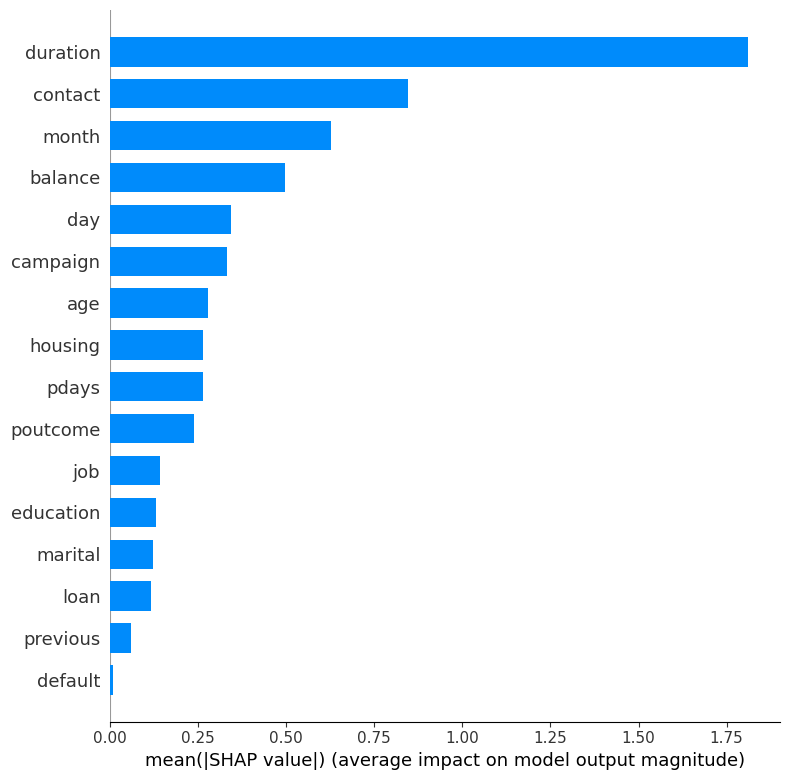

In [40]:
import shap
import matplotlib.pyplot as plt
# 各サンプル × 各特徴の SHAP 値
shap_values = final_model.predict(X_valid, pred_contrib=True)

# shap_valuesは numpy配列（shape: [n_samples, n_features + 1])
# 最後の列は "bias term"（全体平均予測値）
shap_values = shap_values[:, :-1]  # bias列を除外

shap.summary_plot(shap_values, X_valid, plot_type="bar")
plt.show()

In [41]:
test_df[categorical_feats] = test_df[categorical_feats].astype("category")
for col in  categorical_feats:
    le = label_encoders[col]
    test_df[col] = le.transform(test_df[col])

In [42]:
exclude_cols = ['id']
X = test_df.drop(columns=exclude_cols,axis=1)

In [43]:
test_df['y'] = final_model.predict(X)

In [49]:
test_df[['id','y']].to_csv('/home/takato/bita/bank/data/trial.csv', index=False, header=False)